In [1]:
import numpy as np
import copy
from scipy.sparse import lil_matrix, csr_matrix
from scipy.sparse.linalg import spsolve
from collections import deque

def advection_diffusion_model(dem, area, flow_direction, m):
    """
    Returns a function F(U,K,D) that solves:
        [ D*M_diff + K*M_adv ] z = U*b_U + b_elev,
    with outlet‐and‐edge rows overwritten as z = Z0.

    dem:            d.Elevation object (interior may be arbitrary; we only use dem._griddata to read Z0)
    area:           d.Area object (must already be loaded from area_path)
    flow_direction: d.FlowDirectionD8 object (must be loaded from flow_path)
    m:              exponent in advective term

    The returned function signature is:
        Z = output_function(U, K, D)
    where Z is the steady‐state elevation grid.
    """

    # shorthand
    Z0 = dem._griddata           # full elevation grid (only used for BCs)
    A  = area._griddata          # drainage area
    FD = flow_direction._griddata

    dx = dem._georef_info.dx
    dy = dx

    Ny, Nx = A.shape
    valid = np.isfinite(A)

    # find outlet (largest A); if it isn't on a boundary cell, we will snap it to the nearest boundary cell
    j_out, i_out = np.unravel_index(np.nanargmax(A), A.shape)

    # Optimized indexing: use numpy arrays instead of dictionaries for faster lookup
    valid_indices = np.where(valid)
    n = len(valid_indices[0])
    idx_map = np.full((Ny, Nx), -1, dtype=int)
    idx_map[valid_indices] = np.arange(n)
    rev_i = valid_indices[1]  # i coordinates
    rev_j = valid_indices[0]  # j coordinates

    # Pre-compute constants and lookup tables
    inv_dx2 = 1.0 / dx**2
    inv_dy2 = 1.0 / dy**2
    sqrt2 = np.sqrt(2.0)
    
    # D8 offsets
    INT2D = {
        1:  (1, 0),   2:  (1, 1),   4:  (0, 1),   8: (-1, 1),
        16: (-1, 0), 32: (-1, -1), 64: (0, -1), 128:(1, -1)
    }

    # ─── 1. Build pure-diffusion stencil M_diff and pure-advection stencil M_adv ──────────
    M_diff = lil_matrix((n, n), dtype=float)
    M_adv  = lil_matrix((n, n), dtype=float)

    b_U    = np.full(n, -1.0, dtype=float)  # later we will do U * b_U → -U
    b_elev = np.zeros(n, dtype=float)       # we'll fill only BC entries here

    # Vectorized diffusion matrix construction
    laplacian_offsets = [(-1, 0, inv_dx2), (1, 0, inv_dx2), (0, -1, inv_dy2), (0, 1, inv_dy2)]
    
    for k in range(n):
        i, j = rev_i[k], rev_j[k]
        
        # Diffusion part - optimized neighbor checking
        for di, dj, inv in laplacian_offsets:
            ni, nj = i + di, j + dj
            if 0 <= ni < Nx and 0 <= nj < Ny and valid[nj, ni]:
                neighbor_k = idx_map[nj, ni]
                M_diff[k, neighbor_k] += inv
                M_diff[k, k] -= inv
            else:
                M_diff[k, k] -= inv

        # Advection part
        code = FD[j, i]
        if code in INT2D:
            di, dj = INT2D[code]
            ni, nj = i + di, j + dj
            if 0 <= ni < Nx and 0 <= nj < Ny and valid[nj, ni]:
                dL = dx * (sqrt2 if (di != 0 and dj != 0) else 1.0)
                coeff = - (A[j, i]**m) / dL
                neighbor_k = idx_map[nj, ni]
                M_adv[k, k] += coeff
                M_adv[k, neighbor_k] -= coeff

    # ─── 2. Identify all boundary‐and‐outlet BC indices and record their target elevations ──
    # Pre-compute boundary mask
    edges = np.zeros_like(valid, dtype=bool)
    edges[0, :] = edges[-1, :] = edges[:, 0] = edges[:, -1] = True
    
    boundary_mask = edges & valid
    boundary_indices = np.where(boundary_mask)
    bc_inds = []
    bc_vals = np.zeros(n, dtype=float)
    
    for j, i in zip(boundary_indices[0], boundary_indices[1]):
        k = idx_map[j, i]
        bc_inds.append(k)
        bc_vals[k] = Z0[j, i]
        b_U[k] = 0.0

    # Handle outlet
    if not ((0 == j_out or j_out == Ny-1 or 0 == i_out or i_out == Nx-1) and valid[j_out, i_out]):
        found = False
        for (ii, jj) in [(i_out, 0), (i_out, Ny-1), (0, j_out), (Nx-1, j_out)]:
            if valid[jj, ii]:
                i_out, j_out = ii, jj
                found = True
                break
        if not found:
            raise RuntimeError("Cannot force the outlet onto a valid perimeter cell.")

    kout = idx_map[j_out, i_out]
    if kout not in bc_inds:
        bc_inds.append(kout)
        bc_vals[kout] = Z0[j_out, i_out]
        b_U[kout] = 0.0

    # Convert to CSR matrices once for efficiency
    M_diff_csr = M_diff.tocsr()
    M_adv_csr = M_adv.tocsr()
    bc_inds = np.array(bc_inds)

    # ─── 3. Build and return the solver closure ─────────────────────────────────────────────
    def output_function(U, K, D):
        """
        Solve [ D*M_diff + K*M_adv ] z  =  U*b_U + b_elev,
        but with rows in bc_inds overridden so that z[k] = bc_vals[k].

        Returns a 2D array Z (Ny×Nx) of the steady‐state elevation.
        """
        # (a) form the combined matrix and RHS - use CSR arithmetic
        M = D * M_diff_csr + K * M_adv_csr
        b = U * b_U + b_elev

        # (b) impose Dirichlet BCs - vectorized operations
        M = M.tolil()  # Convert to LIL for efficient row operations
        M[bc_inds, :] = 0.0
        M[bc_inds, bc_inds] = 1.0
        b[bc_inds] = bc_vals[bc_inds]

        # (c) solve and scatter back to a full‐grid 2D array
        z_flat = spsolve(M.tocsr(), b)

        Z = np.full_like(Z0, np.nan)
        Z[rev_j, rev_i] = z_flat

        return Z

    return output_function


def partitioned_threshold_model(dem, area, flow_direction, m, U, K):
    """
    Optimized version of partitioned threshold model with pre-computed advective landscape.
    Pre-computes the entire advective topography using area-sorted integration, then
    returns a function that applies thresholding and diffusion efficiently.
    
    Algorithm:
      1) Sort all cells by drainage area (high to low)
      2) Pre-compute advective elevations using finite difference integration
      3) Return function that applies area threshold mask and solves diffusion
    
    This approach is O(N log N) + O(N) and more memory efficient than matrix-based routing.

    Arguments:
      dem            = d.Elevation object; boundary elevations from _griddata
      area           = d.Area object, already loaded
      flow_direction = d.FlowDirectionD8 object, already loaded  
      m              = exponent in detachment-limited law (A^m S^n)
      U              = uplift rate (moved from output function for pre-computation)
      K              = erodibility coefficient (moved from output function)

    Returns:
      A function f(A_crit, D) → (Z_ss, channel_mask)
      where Z_ss is steady-state elevation and channel_mask shows channel cells.
    """

    # ───────────────────────────────────────────────────────────
    # 1) Extract data and build indexing
    # ───────────────────────────────────────────────────────────
    Z0 = dem._griddata  # Boundary elevations
    A = area._griddata  # Drainage area
    FD = flow_direction._griddata  # D8 codes

    dx = dem._georef_info.dx
    dy = dx
    Ny, Nx = A.shape

    valid = np.isfinite(A)
    valid_indices = np.where(valid)
    n = len(valid_indices[0])
    idx_map = np.full((Ny, Nx), -1, dtype=int)
    idx_map[valid_indices] = np.arange(n)
    rev_i = valid_indices[1]
    rev_j = valid_indices[0]

    # Pre-store data in 1D arrays for fast access
    A_flat = A[rev_j, rev_i]
    FD_flat = FD[rev_j, rev_i].astype(int)

    # D8 flow direction offsets
    INT2D = {
        1: (1, 0), 2: (1, 1), 4: (0, 1), 8: (-1, 1),
        16: (-1, 0), 32: (-1, -1), 64: (0, -1), 128: (1, -1)
    }

    # ───────────────────────────────────────────────────────────
    # 2) Pre-compute complete channel network for all cells
    # ───────────────────────────────────────────────────────────
    
    # Pre-compute steady-state slopes: S0 = (U/K) / A^m
    S0_flat = (U / K) / (A_flat ** m)
    
    # Build complete downstream topology for all cells
    downstream_of = np.full(n, -1, dtype=int)
    child_count = np.zeros(n, dtype=int)
    
    for k in range(n):
        i, j = rev_i[k], rev_j[k]
        code = FD_flat[k]
        if code in INT2D:
            di, dj = INT2D[code]
            ni, nj = i + di, j + dj
            if 0 <= ni < Nx and 0 <= nj < Ny and valid[nj, ni]:
                k_down = idx_map[nj, ni]
                downstream_of[k] = k_down
                child_count[k_down] += 1
    
    # Pre-compute channel elevations for ALL cells using topological sorting
    Z_channel_all = np.full(n, np.nan)
    
    # Set ALL boundary cell elevations to measured values
    edges = np.zeros_like(valid, dtype=bool)
    edges[0, :] = edges[-1, :] = edges[:, 0] = edges[:, -1] = True
    boundary_mask = edges & valid
    
    for j, i in zip(*np.where(boundary_mask)):
        k = idx_map[j, i]
        boundary_elev = Z0[j, i] if np.isfinite(Z0[j, i]) else _find_boundary_value(Z0, i, j, Nx, Ny)
        Z_channel_all[k] = boundary_elev
    
    
    # Find outlet for reference
    j_out, i_out = np.unravel_index(np.nanargmax(A), (Ny, Nx))
    k_out = idx_map[j_out, i_out]
    
    # Build upstream neighbor lists for downstream-to-upstream processing
    upstream_neighbors = [[] for _ in range(n)]
    for k in range(n):
        k_down = downstream_of[k]
        if k_down >= 0:
            upstream_neighbors[k_down].append(k)
    
    # Downstream-to-upstream topological sorting
    # Start with boundary cells (which already have elevations)
    initial_queue = [k for k in range(n) if not np.isnan(Z_channel_all[k])]
    queue = deque(initial_queue)
    
    # Debug: Track channel propagation from top boundary
    debug_channel_propagation = True  # Enable for detailed channel debugging
    if debug_channel_propagation:
        print(f"Starting channel propagation with {len(initial_queue)} boundary cells")
        boundary_by_edge = {'first_row_j0': 0, 'last_row_jmax': 0, 'left_i0': 0, 'right_imax': 0}
        for k in initial_queue:
            i, j = rev_i[k], rev_j[k]
            if j == 0: boundary_by_edge['first_row_j0'] += 1
            elif j == Ny-1: boundary_by_edge['last_row_jmax'] += 1
            elif i == 0: boundary_by_edge['left_i0'] += 1
            elif i == Nx-1: boundary_by_edge['right_imax'] += 1
        print(f"Boundary seeds by edge: {boundary_by_edge}")
        print(f"  first_row_j0 = j=0, last_row_jmax = j={Ny-1}")
    
    processed_count = 0
    failed_propagations = []
    boundary_propagation_fails = {'first_row_j0': [], 'last_row_jmax': [], 'left_i0': [], 'right_imax': []}
    
    while queue:
        k_current = queue.popleft()
        
        # Process all upstream neighbors of this cell
        for k_upstream in upstream_neighbors[k_current]:
            if not np.isnan(Z_channel_all[k_upstream]):
                # Already processed
                continue
                
            # Compute elevation for upstream cell
            i, j = rev_i[k_upstream], rev_j[k_upstream]
            z_down = Z_channel_all[k_current]
            i_curr, j_curr = rev_i[k_current], rev_j[k_current]
            
            # Debug: Check for problematic propagation
            if np.isnan(z_down):
                failed_propagations.append((k_current, k_upstream, i_curr, j_curr, i, j, "NaN downstream"))
                # Track which boundary edge this failure stems from
                if j_curr == 0: boundary_propagation_fails['first_row_j0'].append((i_curr, j_curr, i, j))
                elif j_curr == Ny-1: boundary_propagation_fails['last_row_jmax'].append((i_curr, j_curr, i, j))
                elif i_curr == 0: boundary_propagation_fails['left_i0'].append((i_curr, j_curr, i, j))
                elif i_curr == Nx-1: boundary_propagation_fails['right_imax'].append((i_curr, j_curr, i, j))
                continue
            
            code = FD_flat[k_upstream]
            di, dj = INT2D.get(code, (0, 0))
            
            # Debug: Check flow direction validity
            if code not in INT2D:
                failed_propagations.append((k_current, k_upstream, i_curr, j_curr, i, j, f"Invalid FD code: {code}"))
                continue
                
            dL = dx * (np.sqrt(2.0) if (di != 0 and dj != 0) else 1.0)
            s_here = S0_flat[k_upstream]  # Use pre-computed theoretical slope
            
            # Debug: Check slope validity - this is likely the issue!
            if not np.isfinite(s_here):
                failed_propagations.append((k_current, k_upstream, i_curr, j_curr, i, j, f"Invalid slope: {s_here} from A={A_flat[k_upstream]}"))
                # Track boundary-specific slope failures
                if j_curr == 0: boundary_propagation_fails['first_row_j0'].append((i_curr, j_curr, i, j))
                elif j_curr == Ny-1: boundary_propagation_fails['last_row_jmax'].append((i_curr, j_curr, i, j))
                elif i_curr == 0: boundary_propagation_fails['left_i0'].append((i_curr, j_curr, i, j))
                elif i_curr == Nx-1: boundary_propagation_fails['right_imax'].append((i_curr, j_curr, i, j))
                continue
            
            z_here = z_down + s_here * dL
            
            # Debug: Check computed elevation
            if not np.isfinite(z_here):
                failed_propagations.append((k_current, k_upstream, i_curr, j_curr, i, j, f"Invalid elevation: {z_here} = {z_down} + {s_here} * {dL}"))
                continue
            
            Z_channel_all[k_upstream] = z_here
            queue.append(k_upstream)
            processed_count += 1
    
    # Debug: Report channel propagation results focusing on boundary-specific failures
    if debug_channel_propagation:
        print(f"Channel propagation completed: {processed_count} cells processed")
        if failed_propagations:
            print(f"Total failed propagations: {len(failed_propagations)}")
            for k_curr, k_up, i_curr, j_curr, i_up, j_up, reason in failed_propagations[:10]:
                print(f"  ({i_curr},{j_curr}) -> ({i_up},{j_up}): {reason}")
        
        # Report boundary-specific propagation failures
        for edge, failures in boundary_propagation_fails.items():
            if failures:
                print(f"*** {edge} boundary propagation failures: {len(failures)} ***")
                for i_curr, j_curr, i_up, j_up in failures[:3]:  # Show first 3
                    print(f"  Boundary ({i_curr},{j_curr}) -> upstream ({i_up},{j_up}) FAILED")
        
        # Check which boundaries have successful propagation
        final_nan_count = np.sum(np.isnan(Z_channel_all))
        print(f"Final channel NaNs: {final_nan_count}/{n}")
        
        # Check both boundary rows to identify which has the issue
        first_row_cells = [k for k in range(n) if rev_j[k] == 0]  # j=0
        last_row_cells = [k for k in range(n) if rev_j[k] == Ny-1]  # j=Ny-1
        
        first_row_nan_count = sum(1 for k in first_row_cells if np.isnan(Z_channel_all[k]))
        last_row_nan_count = sum(1 for k in last_row_cells if np.isnan(Z_channel_all[k]))
        
        print(f"First row (j=0) channel NaNs: {first_row_nan_count}/{len(first_row_cells)}")
        print(f"Last row (j={Ny-1}) channel NaNs: {last_row_nan_count}/{len(last_row_cells)}")
        
        # The key insight: channels that flow FROM boundary cells, not the boundaries themselves
        if last_row_nan_count > 0:
            print("*** ISSUE CONFIRMED: Channels FLOWING FROM last row (j=Ny-1) have NaN elevations ***")
            print("*** This means boundary cells are fine, but their upstream propagation fails ***")
        elif first_row_nan_count > 0:
            print("*** ISSUE CONFIRMED: Channels FLOWING FROM first row (j=0) have NaN elevations ***")
            print("*** This means boundary cells are fine, but their upstream propagation fails ***")
            
        # Check if the issue is in S0_flat (slope calculation)
        slope_nan_count = np.sum(~np.isfinite(S0_flat))
        if slope_nan_count > 0:
            print(f"*** LIKELY ROOT CAUSE: {slope_nan_count} cells have invalid slopes S0 = (U/K) / A^m ***")
            print("*** Check for A=0 or A=inf in drainage area data ***")
        
        # New diagnostics: Check for disconnected flow networks
        print(f"\n*** DISCONNECTED FLOW ANALYSIS ***")
        print(f"Cells processed by propagation: {processed_count}")
        print(f"Cells with NaN channel elevations: {final_nan_count}")
        print(f"Total valid cells in grid: {n}")
        
        # These NaN cells never got reached by boundary propagation
        unreachable_count = final_nan_count - slope_nan_count
        print(f"Cells unreachable from boundaries: {unreachable_count}")
        
        if unreachable_count > 0:
            print("*** ROOT CAUSE: Interior cells are disconnected from boundary drainage ***")
            print("*** These cells flow in loops or have invalid flow directions ***")
            
            # Find some example unreachable cells
            unreachable_cells = [k for k in range(n) if np.isnan(Z_channel_all[k]) and np.isfinite(S0_flat[k])][:5]
            for k in unreachable_cells[:3]:
                i, j = rev_i[k], rev_j[k]
                code = FD_flat[k]
                area = A_flat[k]
                print(f"  Unreachable cell ({i},{j}): FD={code}, A={area:.1f}")
        
        # Check for cells that flow to nowhere
        cells_with_no_downstream = np.sum(downstream_of == -1)
        print(f"Cells with no downstream connection: {cells_with_no_downstream}")
        
        if cells_with_no_downstream > 0:
            print("*** These cells have invalid flow directions or flow off-grid ***")

    # ───────────────────────────────────────────────────────────
    # 3) Pre-compute diffusion matrix and boundary conditions
    # ───────────────────────────────────────────────────────────
    
    # Build diffusion stencil
    M_base = lil_matrix((n, n), dtype=float)
    inv_dx2 = 1.0 / dx ** 2
    inv_dy2 = 1.0 / dy ** 2
    laplacian_offsets = [(-1, 0, inv_dx2), (1, 0, inv_dx2), (0, -1, inv_dy2), (0, 1, inv_dy2)]
    
    for k in range(n):
        i, j = rev_i[k], rev_j[k]
        for di, dj, inv in laplacian_offsets:
            ni, nj = i + di, j + dj
            if 0 <= ni < Nx and 0 <= nj < Ny and valid[nj, ni]:
                neighbor_k = idx_map[nj, ni]
                M_base[k, neighbor_k] += inv
                M_base[k, k] -= inv
            else:
                M_base[k, k] -= inv

    # Pre-collect boundary indices and values
    edges = np.zeros_like(valid, dtype=bool)
    edges[0, :] = edges[-1, :] = edges[:, 0] = edges[:, -1] = True
    boundary_mask = edges & valid
    boundary_indices = np.where(boundary_mask)
    
    bc_boundary_inds = []
    bc_boundary_vals = np.zeros(n, dtype=float)
    for j, i in zip(boundary_indices[0], boundary_indices[1]):
        k = idx_map[j, i]
        bc_boundary_inds.append(k)
        boundary_val = Z0[j, i] if np.isfinite(Z0[j, i]) else _find_boundary_value(Z0, i, j, Nx, Ny)
        bc_boundary_vals[k] = boundary_val

    # Convert to efficient formats
    M_base_csr = M_base.tocsr()
    bc_boundary_inds = np.array(bc_boundary_inds)

    # ───────────────────────────────────────────────────────────
    # 4) Return the optimized solver function
    # ───────────────────────────────────────────────────────────
    def output_function(A_crit, D, debug=False):
        """
        Apply area threshold and solve diffusion using pre-computed advective landscape.
        
        Args:
          A_crit: Critical drainage area threshold for channels
          D: Diffusivity coefficient
          debug: If True, print diagnostic information about NaN sources
          
        Returns:
          Z_ss: 2D array (Ny × Nx) of steady-state elevations
          channel_mask: 2D array (Ny × Nx) boolean mask of channel cells
        """
        
        # Debug: Check initial state
        if debug:
            print("=== PARTITIONED THRESHOLD MODEL DIAGNOSTICS ===")
            print(f"Grid size: {Ny} x {Nx} = {Ny*Nx} cells")
            print(f"Valid cells: {n}")
            print(f"A_crit: {A_crit}, D: {D}")
            
            # Check input data quality
            nan_boundary_count = np.sum(np.isnan(Z0[boundary_mask]))
            total_boundary_count = np.sum(boundary_mask)
            print(f"Boundary cells with NaN elevation: {nan_boundary_count}/{total_boundary_count}")
            
            invalid_fd_count = np.sum([code not in INT2D for code in FD_flat])
            print(f"Invalid flow direction codes: {invalid_fd_count}/{n}")
            
            nan_area_count = np.sum(~np.isfinite(A_flat))
            print(f"Non-finite drainage areas: {nan_area_count}/{n}")
            
            # Check pre-computed channel elevations
            nan_channel_count = np.sum(np.isnan(Z_channel_all))
            print(f"NaN values in pre-computed channels: {nan_channel_count}/{n}")
            
            if nan_channel_count > 0:
                print("*** WARNING: NaN propagation detected in channel network ***")
                # Check both boundaries to identify which "top" has the issue
                top_boundary_cells_j0 = [k for k in range(n) if rev_j[k] == 0]  # j=0 (first row)
                top_boundary_cells_jmax = [k for k in range(n) if rev_j[k] == Ny-1]  # j=Ny-1 (last row)
                
                top_nan_count_j0 = sum(1 for k in top_boundary_cells_j0 if np.isnan(Z_channel_all[k]))
                top_nan_count_jmax = sum(1 for k in top_boundary_cells_jmax if np.isnan(Z_channel_all[k]))
                
                print(f"First row (j=0) channel NaNs: {top_nan_count_j0}/{len(top_boundary_cells_j0)}")
                print(f"Last row (j={Ny-1}) channel NaNs: {top_nan_count_jmax}/{len(top_boundary_cells_jmax)}")
                
                if top_nan_count_jmax > 0:
                    print("*** CONFIRMED: Last row (j=Ny-1) boundary channels have NaN elevations ***")
                    print("This matches your observation - channels from highest row number are failing")
                elif top_nan_count_j0 > 0:
                    print("*** CONFIRMED: First row (j=0) boundary channels have NaN elevations ***")
        
        # Apply area threshold to determine channel mask
        channel_mask_flat = (A_flat >= A_crit)
        
        # Ensure outlet is always included in channels
        if not channel_mask_flat[k_out]:
            channel_mask_flat[k_out] = True
        
        # Extract pre-computed channel elevations for selected channels
        Z_channel_flat = Z_channel_all.copy()  # Use pre-computed values
        
        # Debug: Check channel selection and values
        if debug:
            channel_count = np.sum(channel_mask_flat)
            nan_in_channels = np.sum(np.isnan(Z_channel_flat[channel_mask_flat]))
            print(f"Channel cells selected: {channel_count}")
            print(f"NaN values in selected channels: {nan_in_channels}/{channel_count}")
            
            if nan_in_channels > 0:
                print("*** ERROR: Selected channel cells contain NaN elevations ***")
                # Find which channels have NaN
                nan_channel_indices = np.where(channel_mask_flat & np.isnan(Z_channel_flat))[0]
                print(f"NaN channel indices: {nan_channel_indices[:10]}...")  # Show first 10
        
        # Create reduced system: solve only for hillslope cells (non-channel, non-boundary)
        is_channel_or_boundary = channel_mask_flat.copy()
        is_channel_or_boundary[bc_boundary_inds] = True
        hillslope_mask = ~is_channel_or_boundary
        
        hillslope_indices = np.where(hillslope_mask)[0]
        n_hillslope = len(hillslope_indices)
        
        # Debug: Check system structure
        if debug:
            boundary_count = len(bc_boundary_inds)
            print(f"Boundary cells: {boundary_count}")
            print(f"Hillslope cells to solve: {n_hillslope}")
            print(f"Total system: {boundary_count + channel_count + n_hillslope} (should equal {n})")
        
        if n_hillslope == 0:
            # All cells are channels or boundaries - no diffusion needed
            z_flat = np.full(n, np.nan)
            z_flat[bc_boundary_inds] = bc_boundary_vals[bc_boundary_inds]
            z_flat[channel_mask_flat] = Z_channel_flat[channel_mask_flat]
            
            if debug:
                print("No hillslope diffusion needed - all cells are channels or boundaries")
        else:
            # Build reduced index mapping: hillslope cell index -> reduced matrix index
            hillslope_to_reduced = np.full(n, -1, dtype=int)
            hillslope_to_reduced[hillslope_indices] = np.arange(n_hillslope)
            
            # Build reduced diffusion matrix for hillslope cells only
            M_reduced = lil_matrix((n_hillslope, n_hillslope), dtype=float)
            b_reduced = np.full(n_hillslope, -U, dtype=float)  # U is from closure
            
            # Debug: Track diffusion matrix construction issues
            if debug:
                nan_bc_neighbors = 0
                nan_channel_neighbors = 0
                invalid_neighbors = 0
                print("Building diffusion matrix for hillslope cells...")
            
            for idx, k in enumerate(hillslope_indices):
                i, j = rev_i[k], rev_j[k]
                
                # Add diffusion stencil for this hillslope cell
                for di, dj, inv in [(-1, 0, inv_dx2), (1, 0, inv_dx2), (0, -1, inv_dy2), (0, 1, inv_dy2)]:
                    ni, nj = i + di, j + dj
                    if 0 <= ni < Nx and 0 <= nj < Ny and valid[nj, ni]:
                        neighbor_k = idx_map[nj, ni]
                        if hillslope_mask[neighbor_k]:
                            # Neighbor is also a hillslope cell - add to matrix
                            neighbor_idx = hillslope_to_reduced[neighbor_k]
                            M_reduced[idx, neighbor_idx] += D * inv
                            M_reduced[idx, idx] -= D * inv
                        else:
                            # Neighbor is channel/boundary - contributes to RHS
                            if channel_mask_flat[neighbor_k]:
                                neighbor_val = Z_channel_flat[neighbor_k]
                                if debug and np.isnan(neighbor_val):
                                    nan_channel_neighbors += 1
                                    if nan_channel_neighbors <= 3:  # Only show first few examples
                                        hi, hj = rev_i[k], rev_j[k]
                                        ni_coord, nj_coord = rev_i[neighbor_k], rev_j[neighbor_k]
                                        print(f"    NaN channel neighbor at ({ni_coord},{nj_coord}) for hillslope cell ({hi},{hj})")
                            else:
                                neighbor_val = bc_boundary_vals[neighbor_k]
                                if debug and np.isnan(neighbor_val):
                                    nan_bc_neighbors += 1
                                    if nan_bc_neighbors <= 3:  # Only show first few examples
                                        hi, hj = rev_i[k], rev_j[k]
                                        ni_coord, nj_coord = rev_i[neighbor_k], rev_j[neighbor_k]
                                        print(f"    NaN boundary neighbor at ({ni_coord},{nj_coord}) for hillslope cell ({hi},{hj})")
                            
                            if debug and np.isnan(neighbor_val):
                                invalid_neighbors += 1
                            
                            b_reduced[idx] -= D * inv * neighbor_val
                            M_reduced[idx, idx] -= D * inv
                    else:
                        # Outside domain - standard boundary condition
                        M_reduced[idx, idx] -= D * inv
            
            # Debug: Report diffusion matrix construction problems
            if debug:
                nan_rhs_count = np.sum(np.isnan(b_reduced))
                print(f"Diffusion matrix construction completed:")
                print(f"  NaN channel neighbors: {nan_channel_neighbors}")
                print(f"  NaN boundary neighbors: {nan_bc_neighbors}")
                print(f"  Total invalid neighbors: {invalid_neighbors}")
                print(f"  NaN values in RHS vector: {nan_rhs_count}/{len(b_reduced)}")
                
                if nan_rhs_count > 0:
                    print("*** ERROR: NaN values in diffusion RHS - this will cause solver failure ***")
                    # Find which hillslope cells have NaN RHS
                    nan_rhs_indices = np.where(np.isnan(b_reduced))[0]
                    print(f"Hillslope cells with NaN RHS: {nan_rhs_indices[:10]}...")  # Show first 10
                
                # Check matrix diagonal for zeros or NaN
                M_csr = M_reduced.tocsr()
                diag = M_csr.diagonal()
                zero_diag_count = np.sum(np.abs(diag) < 1e-15)
                nan_diag_count = np.sum(np.isnan(diag))
                print(f"Matrix diagonal issues: {zero_diag_count} zeros, {nan_diag_count} NaNs")
                
                if zero_diag_count > 0 or nan_diag_count > 0:
                    print("*** ERROR: Matrix has zero/NaN diagonal entries - singular system ***")
            
            # Debug: Check matrix conditioning before solving
            if debug:
                M_csr = M_reduced.tocsr()
                print(f"Diffusion matrix size: {M_csr.shape}")
                print(f"Matrix non-zeros: {M_csr.nnz}")
                
                # Check for problematic boundary conditions
                nan_bc_count = np.sum(np.isnan(bc_boundary_vals[bc_boundary_inds]))
                nan_channel_bc_count = np.sum(np.isnan(Z_channel_flat[channel_mask_flat]))
                print(f"NaN boundary conditions: {nan_bc_count}")
                print(f"NaN channel boundary conditions: {nan_channel_bc_count}")
                
                if nan_bc_count > 0 or nan_channel_bc_count > 0:
                    print("*** ERROR: NaN boundary conditions will cause solver failure ***")
            
            # Solve reduced system
            try:
                z_hillslope = spsolve(M_reduced.tocsr(), b_reduced)
                
                if debug:
                    nan_solution_count = np.sum(np.isnan(z_hillslope))
                    if nan_solution_count > 0:
                        print(f"*** ERROR: Solver returned {nan_solution_count} NaN values ***")
                        print("This indicates matrix conditioning problems or NaN boundary conditions")
                    else:
                        print("Diffusion solver completed successfully")
                        
            except Exception as e:
                if debug:
                    print(f"*** ERROR: Solver failed with exception: {e} ***")
                z_hillslope = np.full(n_hillslope, np.nan)
            
            # Scatter results back to full system
            z_flat = np.full(n, np.nan)
            z_flat[hillslope_indices] = z_hillslope
            z_flat[bc_boundary_inds] = bc_boundary_vals[bc_boundary_inds]
            z_flat[channel_mask_flat] = Z_channel_flat[channel_mask_flat]
        
        # Scatter back to 2D grid
        Z_ss = np.full((Ny, Nx), np.nan)
        Z_ss[rev_j, rev_i] = z_flat
        
        # Create 2D channel mask
        channel_mask_2d = np.zeros((Ny, Nx), dtype=bool)
        channel_mask_2d[rev_j, rev_i] = channel_mask_flat
        
        # Debug: Final summary
        if debug:
            final_nan_count = np.sum(np.isnan(Z_ss))
            total_cells = Ny * Nx
            print(f"Final result: {final_nan_count}/{total_cells} cells are NaN")
            
            # Check if NaNs are only at boundaries as expected
            interior_mask = np.ones((Ny, Nx), dtype=bool)
            interior_mask[0, :] = interior_mask[-1, :] = interior_mask[:, 0] = interior_mask[:, -1] = False
            interior_nan_count = np.sum(np.isnan(Z_ss) & interior_mask)
            
            if interior_nan_count > 0:
                print(f"*** PROBLEM: {interior_nan_count} interior cells are NaN (should be 0) ***")
                print("This confirms the reported issue - check the ERROR messages above")
            else:
                print("SUCCESS: NaN values are only at boundaries as expected")
            
            print("=== END DIAGNOSTICS ===\n")
        
        return Z_ss, channel_mask_2d

    return output_function


def partitioned_threshold_model_nonlinear(dem, area, flow_direction, m, U, K):
    """
    Nonlinear version of partitioned threshold model with slope-dependent diffusivity.
    
    Uses D_eff = D_linear / (1 - (S / S_c)^2) for hillslope diffusion, requiring
    iterative solution since diffusivity depends on slopes.
    
    Arguments:
      dem            = d.Elevation object; boundary elevations from _griddata
      area           = d.Area object, already loaded
      flow_direction = d.FlowDirectionD8 object, already loaded  
      m              = exponent in detachment-limited law (A^m S^n)
      U              = uplift rate
      K              = erodibility coefficient

    Returns:
      A function f(A_crit, D_linear, S_c) → (Z_ss, channel_mask)
      where Z_ss is steady-state elevation and channel_mask shows channel cells.
    """
    
    # ───────────────────────────────────────────────────────────
    # 1) Extract data and build indexing (same as linear version)
    # ───────────────────────────────────────────────────────────
    Z0 = dem._griddata  # Boundary elevations
    A = area._griddata  # Drainage area
    FD = flow_direction._griddata  # D8 codes

    dx = dem._georef_info.dx
    dy = dx
    Ny, Nx = A.shape

    valid = np.isfinite(A)
    valid_indices = np.where(valid)
    n = len(valid_indices[0])
    idx_map = np.full((Ny, Nx), -1, dtype=int)
    idx_map[valid_indices] = np.arange(n)
    rev_i = valid_indices[1]
    rev_j = valid_indices[0]

    # Pre-store data in 1D arrays for fast access
    A_flat = A[rev_j, rev_i]
    FD_flat = FD[rev_j, rev_i].astype(int)

    # D8 flow direction offsets
    INT2D = {
        1: (1, 0), 2: (1, 1), 4: (0, 1), 8: (-1, 1),
        16: (-1, 0), 32: (-1, -1), 64: (0, -1), 128: (1, -1)
    }

    # ───────────────────────────────────────────────────────────
    # 2) Pre-compute complete channel network for all cells (same as linear)
    # ───────────────────────────────────────────────────────────
    
    # Pre-compute steady-state slopes: S0 = (U/K) / A^m
    S0_flat = (U / K) / (A_flat ** m)
    
    # Build complete downstream topology for all cells
    downstream_of = np.full(n, -1, dtype=int)
    child_count = np.zeros(n, dtype=int)
    
    for k in range(n):
        i, j = rev_i[k], rev_j[k]
        code = FD_flat[k]
        if code in INT2D:
            di, dj = INT2D[code]
            ni, nj = i + di, j + dj
            if 0 <= ni < Nx and 0 <= nj < Ny and valid[nj, ni]:
                k_down = idx_map[nj, ni]
                downstream_of[k] = k_down
                child_count[k_down] += 1
    
    # Pre-compute channel elevations for ALL cells using topological sorting
    Z_channel_all = np.full(n, np.nan)
    
    # Set ALL boundary cell elevations to measured values
    edges = np.zeros_like(valid, dtype=bool)
    edges[0, :] = edges[-1, :] = edges[:, 0] = edges[:, -1] = True
    boundary_mask = edges & valid
    
    for j, i in zip(*np.where(boundary_mask)):
        k = idx_map[j, i]
        boundary_elev = Z0[j, i] if np.isfinite(Z0[j, i]) else _find_boundary_value(Z0, i, j, Nx, Ny)
        Z_channel_all[k] = boundary_elev
    
    # Find outlet for reference
    j_out, i_out = np.unravel_index(np.nanargmax(A), (Ny, Nx))
    k_out = idx_map[j_out, i_out]
    
    # Build upstream neighbor lists for downstream-to-upstream processing
    upstream_neighbors = [[] for _ in range(n)]
    for k in range(n):
        k_down = downstream_of[k]
        if k_down >= 0:
            upstream_neighbors[k_down].append(k)
    
    # Downstream-to-upstream topological sorting
    # Start with boundary cells (which already have elevations)
    queue = deque([k for k in range(n) if not np.isnan(Z_channel_all[k])])
    
    while queue:
        k_current = queue.popleft()
        
        # Process all upstream neighbors of this cell
        for k_upstream in upstream_neighbors[k_current]:
            if not np.isnan(Z_channel_all[k_upstream]):
                # Already processed
                continue
                
            # Compute elevation for upstream cell
            i, j = rev_i[k_upstream], rev_j[k_upstream]
            z_down = Z_channel_all[k_current]
            
            code = FD_flat[k_upstream]
            di, dj = INT2D.get(code, (0, 0))
            dL = dx * (np.sqrt(2.0) if (di != 0 and dj != 0) else 1.0)
            s_here = S0_flat[k_upstream]  # Use pre-computed theoretical slope
            z_here = z_down + s_here * dL
            
            Z_channel_all[k_upstream] = z_here
            queue.append(k_upstream)

    # ───────────────────────────────────────────────────────────
    # 3) Pre-compute base diffusion stencil structure (same as linear)
    # ───────────────────────────────────────────────────────────
    
    # Pre-collect boundary indices and values
    bc_boundary_inds = []
    bc_boundary_vals = np.zeros(n, dtype=float)
    for j, i in zip(*np.where(boundary_mask)):
        k = idx_map[j, i]
        bc_boundary_inds.append(k)
        bc_boundary_vals[k] = Z0[j, i]

    bc_boundary_inds = np.array(bc_boundary_inds)

    # ───────────────────────────────────────────────────────────
    # 4) Return the nonlinear solver function
    # ───────────────────────────────────────────────────────────
    def output_function(A_crit, D_linear, S_c, max_iter=50, tol=1e-6):
        """
        Apply area threshold and solve nonlinear diffusion.
        
        Args:
          A_crit: Critical drainage area threshold for channels
          D_linear: Linear diffusivity coefficient
          S_c: Critical slope for nonlinear diffusion
          max_iter: Maximum iterations for nonlinear solver
          tol: Convergence tolerance
          
        Returns:
          Z_ss: 2D array (Ny × Nx) of steady-state elevations
          channel_mask: 2D array (Ny × Nx) boolean mask of channel cells
        """
        
        # Apply area threshold to determine channel mask
        channel_mask_flat = (A_flat >= A_crit)
        
        # Ensure outlet is always included in channels
        if not channel_mask_flat[k_out]:
            channel_mask_flat[k_out] = True
        
        # Extract pre-computed channel elevations for selected channels
        Z_channel_flat = Z_channel_all.copy()
        
        # Create reduced system: solve only for hillslope cells
        is_channel_or_boundary = channel_mask_flat.copy()
        is_channel_or_boundary[bc_boundary_inds] = True
        hillslope_mask = ~is_channel_or_boundary
        
        hillslope_indices = np.where(hillslope_mask)[0]
        n_hillslope = len(hillslope_indices)
        
        if n_hillslope == 0:
            # All cells are channels or boundaries - no diffusion needed
            z_flat = np.full(n, np.nan)
            z_flat[bc_boundary_inds] = bc_boundary_vals[bc_boundary_inds]
            z_flat[channel_mask_flat] = Z_channel_flat[channel_mask_flat]
        else:
            # Build reduced index mapping
            hillslope_to_reduced = np.full(n, -1, dtype=int)
            hillslope_to_reduced[hillslope_indices] = np.arange(n_hillslope)
            
            # Initialize with linear diffusion solution
            z_flat_prev = _solve_linear_diffusion(hillslope_indices, hillslope_to_reduced, 
                                                D_linear, Z_channel_flat, channel_mask_flat,
                                                bc_boundary_inds, bc_boundary_vals, hillslope_mask)
            
            # Iterative nonlinear solver
            for iteration in range(max_iter):
                # Compute slopes for current solution
                slopes = _compute_slopes(z_flat_prev, hillslope_indices)
                
                # Compute nonlinear diffusivity: D_eff = D_linear / (1 - (S/S_c)^2)
                slope_ratio = slopes / S_c
                # Clip to prevent division by zero near critical slope
                slope_ratio = np.clip(slope_ratio, -0.99, 0.99)
                D_eff = D_linear / (1 - slope_ratio**2)
                
                # Solve with updated diffusivity
                z_flat_new = _solve_nonlinear_diffusion(hillslope_indices, hillslope_to_reduced,
                                                      D_eff, Z_channel_flat, channel_mask_flat,
                                                      bc_boundary_inds, bc_boundary_vals, hillslope_mask)
                
                # Check convergence
                hillslope_change = np.max(np.abs(z_flat_new[hillslope_indices] - z_flat_prev[hillslope_indices]))
                if hillslope_change < tol:
                    break
                    
                z_flat_prev = z_flat_new.copy()
            
            z_flat = z_flat_new
        
        # Scatter back to 2D grid
        Z_ss = np.full((Ny, Nx), np.nan)
        Z_ss[rev_j, rev_i] = z_flat
        
        # Create 2D channel mask
        channel_mask_2d = np.zeros((Ny, Nx), dtype=bool)
        channel_mask_2d[rev_j, rev_i] = channel_mask_flat
        
        return Z_ss, channel_mask_2d
    
    # Helper functions for nonlinear solver
    def _solve_linear_diffusion(hillslope_indices, hillslope_to_reduced, D, Z_channel_flat, 
                              channel_mask_flat, bc_boundary_inds, bc_boundary_vals, hillslope_mask):
        """Solve linear diffusion (used for initialization)"""
        n_hillslope = len(hillslope_indices)
        M_reduced = lil_matrix((n_hillslope, n_hillslope), dtype=float)
        b_reduced = np.full(n_hillslope, -U, dtype=float)
        
        inv_dx2 = 1.0 / dx ** 2
        inv_dy2 = 1.0 / dy ** 2
        
        for idx, k in enumerate(hillslope_indices):
            i, j = rev_i[k], rev_j[k]
            
            for di, dj, inv in [(-1, 0, inv_dx2), (1, 0, inv_dx2), (0, -1, inv_dy2), (0, 1, inv_dy2)]:
                ni, nj = i + di, j + dj
                if 0 <= ni < Nx and 0 <= nj < Ny and valid[nj, ni]:
                    neighbor_k = idx_map[nj, ni]
                    if hillslope_mask[neighbor_k]:
                        neighbor_idx = hillslope_to_reduced[neighbor_k]
                        M_reduced[idx, neighbor_idx] += D * inv
                        M_reduced[idx, idx] -= D * inv
                    else:
                        if channel_mask_flat[neighbor_k]:
                            neighbor_val = Z_channel_flat[neighbor_k]
                        else:
                            neighbor_val = bc_boundary_vals[neighbor_k]
                        b_reduced[idx] -= D * inv * neighbor_val
                        M_reduced[idx, idx] -= D * inv
                else:
                    M_reduced[idx, idx] -= D * inv
        
        z_hillslope = spsolve(M_reduced.tocsr(), b_reduced)
        
        z_flat = np.full(n, np.nan)
        z_flat[hillslope_indices] = z_hillslope
        z_flat[bc_boundary_inds] = bc_boundary_vals[bc_boundary_inds]
        z_flat[channel_mask_flat] = Z_channel_flat[channel_mask_flat]
        
        return z_flat
    
    def _compute_slopes(z_flat, hillslope_indices):
        """Compute slopes for hillslope cells"""
        slopes = np.zeros(len(hillslope_indices))
        
        for idx, k in enumerate(hillslope_indices):
            i, j = rev_i[k], rev_j[k]
            z_center = z_flat[k]
            
            # Compute gradient using finite differences
            dzdi = 0.0
            dzdj = 0.0
            count = 0
            
            # X-direction gradient
            if i > 0 and valid[j, i-1]:
                k_left = idx_map[j, i-1]
                dzdi -= (z_flat[k_left] - z_center) / dx
                count += 1
            if i < Nx-1 and valid[j, i+1]:
                k_right = idx_map[j, i+1]
                dzdi += (z_flat[k_right] - z_center) / dx
                count += 1
            if count > 0:
                dzdi /= count
                
            count = 0
            # Y-direction gradient  
            if j > 0 and valid[j-1, i]:
                k_down = idx_map[j-1, i]
                dzdj -= (z_flat[k_down] - z_center) / dy
                count += 1
            if j < Ny-1 and valid[j+1, i]:
                k_up = idx_map[j+1, i]
                dzdj += (z_flat[k_up] - z_center) / dy
                count += 1
            if count > 0:
                dzdj /= count
            
            slopes[idx] = np.sqrt(dzdi**2 + dzdj**2)
        
        return slopes
    
    def _solve_nonlinear_diffusion(hillslope_indices, hillslope_to_reduced, D_eff, Z_channel_flat,
                                 channel_mask_flat, bc_boundary_inds, bc_boundary_vals, hillslope_mask):
        """Solve diffusion with spatially varying diffusivity"""
        n_hillslope = len(hillslope_indices)
        M_reduced = lil_matrix((n_hillslope, n_hillslope), dtype=float)
        b_reduced = np.full(n_hillslope, -U, dtype=float)
        
        inv_dx2 = 1.0 / dx ** 2
        inv_dy2 = 1.0 / dy ** 2
        
        for idx, k in enumerate(hillslope_indices):
            i, j = rev_i[k], rev_j[k]
            D_here = D_eff[idx]
            
            for di, dj, inv in [(-1, 0, inv_dx2), (1, 0, inv_dx2), (0, -1, inv_dy2), (0, 1, inv_dy2)]:
                ni, nj = i + di, j + dj
                if 0 <= ni < Nx and 0 <= nj < Ny and valid[nj, ni]:
                    neighbor_k = idx_map[nj, ni]
                    if hillslope_mask[neighbor_k]:
                        neighbor_idx = hillslope_to_reduced[neighbor_k]
                        M_reduced[idx, neighbor_idx] += D_here * inv
                        M_reduced[idx, idx] -= D_here * inv
                    else:
                        if channel_mask_flat[neighbor_k]:
                            neighbor_val = Z_channel_flat[neighbor_k]
                        else:
                            neighbor_val = bc_boundary_vals[neighbor_k]
                        b_reduced[idx] -= D_here * inv * neighbor_val
                        M_reduced[idx, idx] -= D_here * inv
                else:
                    M_reduced[idx, idx] -= D_here * inv
        
        z_hillslope = spsolve(M_reduced.tocsr(), b_reduced)
        
        z_flat = np.full(n, np.nan)
        z_flat[hillslope_indices] = z_hillslope
        z_flat[bc_boundary_inds] = bc_boundary_vals[bc_boundary_inds]
        z_flat[channel_mask_flat] = Z_channel_flat[channel_mask_flat]
        
        return z_flat

    return output_function


def _find_boundary_value(Z0, i, j, Nx, Ny):
    """Helper function to find a valid boundary value for stranded channel cells."""
    # Try left edge
    if np.isfinite(Z0[j, 0]):
        return Z0[j, 0]
    # Try right edge  
    elif np.isfinite(Z0[j, Nx - 1]):
        return Z0[j, Nx - 1]
    # Try top edge
    elif np.isfinite(Z0[0, i]):
        return Z0[0, i]
    # Try bottom edge
    elif np.isfinite(Z0[Ny - 1, i]):
        return Z0[Ny - 1, i]
    else:
        # All boundary edges have NaN - this is the root cause of NaN propagation
        print(f"*** CRITICAL ERROR in _find_boundary_value: All boundary edges contain NaN for cell ({i},{j}) ***")
        print(f"Left: {Z0[j, 0]}, Right: {Z0[j, Nx-1]}, Top: {Z0[0, i]}, Bottom: {Z0[Ny-1, i]}")
        return np.nan

In [2]:
import TopoAnalysis.dem as d 
import numpy as np
from scipy.stats import linregress
import matplotlib.pylab as plt

def plot_maps_area_slope(dem, area, flow_direction, Z_model, channel_mask = None):
    # Rebuild Elevation object from array
    Z_filled = Z_model.copy()
    elev_model = d.Elevation()
    elev_model._griddata = Z_filled
    elev_model._georef_info = dem._georef_info
    elev_model._nodata_value = np.nan

    slope_orig_obj = d.ChannelSlopeWithSmoothing(
        elevation=dem,
        area=area,
        flow_direction=flow_direction,
        vertical_interval=10,
        min_area=2000
    )

    slope_model_obj = d.ChannelSlopeWithSmoothing(
        elevation=elev_model,
        area=area,
        flow_direction=flow_direction,
        vertical_interval=10,
        min_area=2000
    )

    S_obs = slope_orig_obj._griddata
    S_mod = slope_model_obj._griddata
    A_orig = area._griddata
    Z_orig = dem._griddata

    if channel_mask is not None:
        mask = (channel_mask) & np.isfinite(S_obs) & np.isfinite(S_mod) & np.isfinite(A_orig)
    else:
        mask = np.isfinite(S_obs) & np.isfinite(S_mod) & np.isfinite(A_orig)
    A = A_orig[mask]
    S1 = S_obs[mask]
    S2 = S_mod[mask]

    logA = np.log10(A)
    logS1 = np.log10(S1)
    logS2 = np.log10(S2)

    min_elevation = np.nanmin(dem._griddata)
    max_elevation = np.nanmax(dem._griddata)

    slope1, intercept1, *_ = linregress(logA, logS1)
    slope2, intercept2, *_ = linregress(logA, logS2)
    ks1 = 10**intercept1
    ks2 = 10**intercept2

    fig, axes = plt.subplots(1, 4, figsize=(18, 5), gridspec_kw={'width_ratios': [3, 3, 0.25, 4]})
    axes[0].imshow(dem._griddata, cmap='terrain', origin='lower', vmin = min_elevation, vmax = max_elevation)
    axes[0].set_title("Original Elevation")
    axes[0].axis("off")

    im = axes[1].imshow(Z_model, cmap='terrain', origin='lower', vmin = min_elevation, vmax = max_elevation)
    axes[1].set_title("Modeled Elevation")
    axes[1].axis("off")

    A_fit = np.logspace(np.log10(np.min(A)), np.log10(np.max(A)), 200)
    S_fit1 = ks1 * A_fit ** slope1
    S_fit2 = ks2 * A_fit ** slope2

    fig.colorbar(im, cax=axes[2], orientation='vertical')

    axes[3].loglog(A, S1, '.', alpha=0.3, label='Original')
    axes[3].loglog(A, S2, '.', alpha=0.3, label='Modeled')
    axes[3].loglog(A_fit, S_fit1, 'k--', lw=2, label=f"Original fit: k_s={ks1:.2e}, theta={slope1:.2f}")
    axes[3].loglog(A_fit, S_fit2, 'r--', lw=2, label=f"Modeled fit: k_s={ks2:.2e}, theta={slope2:.2f}")
    axes[3].set_xlabel("Drainage Area A (m²)")
    axes[3].set_ylabel("Slope S")
    axes[3].set_title("Slope–Area Comparison")
    axes[3].legend()
    axes[3].grid(True, which='both', ls='--')

    plt.tight_layout()
    plt.show()

In [3]:
"""
UPDATED MAIN LOOP + RESULTS STRUCTURE (adds Ks_obs, ratio, CSV export)
and includes the NEW plots (ratio vs dx + exponent bars), plus the simple Ks_mod vs dx plot.

What this code does per (location, tile, dx):

1) Start from original observed elevation field (your loaded 1 m filled grid)
2) Downsample to target resolution dx (nan-aware)
3) Recompute hydrology at that dx: Filled -> FlowDirectionD8 -> Area
4) Run your chi integrator / solver to reconstruct synthetic (modeled) elevation field
   - Here: uses `advection_diffusion_model(...)` closure, because that is what your pipeline currently expects.
   - If your chi-integrator has a different factory/signature, swap it in at the marked line.
5) Compute Ks_obs from the observed elevation at that dx (using same fd/area, fixed theta)
6) Compute Ks_mod from the synthetic elevation at that dx (same fd/area, fixed theta)
7) Compute ratio = Ks_mod / Ks_obs
8) Save all_results + plot_dict + write CSV
9) Plot:
   A) Ks_mod vs dx (simple)
   B) Ratio vs dx (per-tile faint lines + median±IQR by loc + ratio=1 reference + slope guide)
   C) Per-tile exponent alpha_R in ratio ~ dx^{-alpha_R} (with optional bootstrap CI)
"""

import os
import copy
import csv
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from matplotlib.ticker import LogLocator

import TopoAnalysis.dem as d

# ============================================================
# REQUIRED: bring your solver factory into scope
# ============================================================
# Must provide:
#   advection_diffusion_model(dem_obj, area_obj, fd_obj, theta) -> callable(U,K,D)->Z_model
# If you are actually using a chi-integrator with a different API, swap it in below
# at the line marked:  >>> SOLVER FACTORY <<<


# ============================================================
# USER CONFIG
# ============================================================
BASE_ROOT = "/Users/scdobbs/Desktop/Folders/Active_manuscripts/Geomorph_project/Final_models_Nov_2025/grids"

# Log-spaced dx targets (unique, sorted)
N_DX = 25
DX_TARGETS = np.logspace(np.log10(5.0), np.log10(100.0), N_DX)  # <-- 1 m to 30 m per your stated procedure
DX_TARGETS = np.unique(DX_TARGETS)
DX_TARGETS = np.sort(DX_TARGETS).tolist()

MIN_AREA = 1E5
VERTICAL_INTERVAL = 10
RESAMPLE_ORDER = 1  # 1=bilinear, 3=bicubic

# Output CSV path
OUT_CSV = os.path.join(BASE_ROOT, "ks_resolution_ratio_results-1E5-AREA-coarser.csv")

# Plot style (keep your current)
plt.rcParams.update({
    "figure.dpi": 300,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica", "Arial", "DejaVu Sans"],
    "font.size": 8,
    "axes.labelsize": 8,
    "axes.titlesize": 8,
    "legend.fontsize": 7,
    "axes.linewidth": 0.5,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.top": True,
    "ytick.right": True,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    "xtick.major.width": 0.5,
    "ytick.major.width": 0.5,
    "xtick.minor.width": 0.4,
    "ytick.minor.width": 0.4,
    "savefig.bbox": "tight",
    "savefig.dpi": 300,
})

# ============================================================
# INPUT PARAMETERS
# ============================================================
U_BY_LOC = {"GM": 1.47e-4, "AP": 5.5e-5}

KD_GM = {
    1: (2.2e-05, 1.0e-02),
    2: (6.1e-05, 1.0e-02),
    3: (1.9e-05, 2.1e-02),
    4: (3.5e-05, 9.8e-03),
    5: (5.9e-05, 9.0e-03),
}
KD_AP = {
    1: (4.0e-07, 2.8e-03),
    2: (2.9e-07, 2.8e-03),
    3: (4.9e-07, 2.7e-03),
    4: (2.0e-06, 2.5e-03),
    5: (3.6e-06, 2.5e-03),
}

THETA_GM = {1: 0.379, 2: 0.308, 3: 0.417, 4: 0.313, 5: 0.300}
THETA_AP = {1: 0.562, 2: 0.592, 3: 0.542, 4: 0.438, 5: 0.400}

# ============================================================
# Helpers: file roots + nan-aware resampling from 1 m base
# ============================================================
def tile_dir(location, tile_idx):
    return os.path.join(BASE_ROOT, location, f"Tile_{tile_idx}")

def root_1m_filled(location, tile_idx):
    base = tile_dir(location, tile_idx)
    p = os.path.join(base, f"{location}_1m_best_tile_filled")
    if not os.path.exists(p):
        raise FileNotFoundError(f"Missing 1m filled root: {p}")
    return p

def _infer_dx_from_georef(gi):
    dx = np.nan
    dy = np.nan
    gt = getattr(gi, "geoTransform", None)

    if gt is not None and gt not in (0, "0"):
        try:
            gt = tuple(gt)
            if len(gt) >= 6:
                dx = float(gt[1])
                dy = abs(float(gt[5]))
        except Exception:
            pass

    if not np.isfinite(dx):
        try:
            dx_attr = float(getattr(gi, "dx", np.nan))
            if np.isfinite(dx_attr) and dx_attr > 0:
                dx = dx_attr
        except Exception:
            pass

    if np.isfinite(dx) and (not np.isfinite(dy)):
        dy = dx

    return dx, dy

def _nanaware_zoom(grid, zoom_yx, order=1):
    grid = np.asarray(grid, dtype=float)
    w = np.isfinite(grid).astype(float)
    v = np.where(np.isfinite(grid), grid, 0.0)

    v2 = zoom(v, zoom=zoom_yx, order=order, mode="nearest", prefilter=(order > 1))
    w2 = zoom(w, zoom=zoom_yx, order=1, mode="nearest")

    out = v2 / np.where(w2 > 0, w2, np.nan)
    out[w2 < 0.5] = np.nan
    return out

def resample_from_1m(dem_1m_filled, dx_target, order=1):
    gi = dem_1m_filled._georef_info
    old_dx, old_dy = _infer_dx_from_georef(gi)
    if not np.isfinite(old_dx) or old_dx <= 0:
        old_dx = 1.0
    if not np.isfinite(old_dy) or old_dy <= 0:
        old_dy = old_dx

    zx = old_dx / float(dx_target)
    zy = old_dy / float(dx_target)

    new_grid = _nanaware_zoom(dem_1m_filled._griddata, (zy, zx), order=order)

    new_obj = copy.deepcopy(dem_1m_filled)
    new_obj._griddata = new_grid

    gi2 = copy.deepcopy(gi)
    gi2.dx = float(dx_target)
    gi2.nx = int(new_grid.shape[1])
    gi2.ny = int(new_grid.shape[0])

    gt = getattr(gi2, "geoTransform", None)
    try:
        if gt is not None and gt not in (0, "0"):
            gt = list(tuple(gt))
            if len(gt) >= 6:
                gt[1] = float(dx_target)
                gt[5] = -float(dx_target)
                gi2.geoTransform = tuple(gt)
    except Exception:
        pass

    new_obj._georef_info = gi2
    return new_obj

# ============================================================
# KS estimation utilities (fixed theta)
# ============================================================
def ks_from_loglog_fixed_theta(A, S, theta_fixed):
    logA = np.log10(A)
    logS = np.log10(S)

    theta = float(theta_fixed)
    y = logS + theta * logA
    logKs = np.nanmean(y)
    Ks = 10.0 ** logKs

    yhat = logKs - theta * logA
    ss_res = np.sum((logS - yhat) ** 2)
    ss_tot = np.sum((logS - np.mean(logS)) ** 2)
    r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else np.nan
    return float(Ks), float(theta), float(r2)

def slope_area_arrays_from_elevation(elev_obj, area_obj, fd_obj,
                                     min_area=MIN_AREA, vertical_interval=VERTICAL_INTERVAL):
    """
    Compute slope-area samples from an elevation object (TopoAnalysis grid)
    using the provided area + flow direction objects (must be consistent).
    """
    slope_obj = d.ChannelSlopeWithSmoothing(
        elevation=elev_obj,
        area=area_obj,
        flow_direction=fd_obj,
        vertical_interval=vertical_interval,
        min_area=min_area
    )
    S = slope_obj._griddata
    A = area_obj._griddata
    m = np.isfinite(S) & np.isfinite(A) & (S > 0) & (A >= float(min_area))
    return A[m].astype(float), S[m].astype(float)

def ks_obs_from_observed(filled_obs, area, fd, theta):
    A_obs, S_obs = slope_area_arrays_from_elevation(filled_obs, area, fd)
    if A_obs.size == 0:
        return np.nan, np.nan, 0, np.nan
    Ks_obs, _, r2_obs = ks_from_loglog_fixed_theta(A_obs, S_obs, theta_fixed=theta)
    return float(Ks_obs), float(r2_obs), int(A_obs.size), float(np.nanmax(A_obs))

def ks_mod_from_modeled(Z_model, georef_template_dem, area, fd, theta):
    dem_model = d.Elevation()
    dem_model._griddata = np.asarray(Z_model, dtype=float)
    dem_model._georef_info = georef_template_dem._georef_info
    dem_model._nodata_value = np.nan

    A_mod, S_mod = slope_area_arrays_from_elevation(dem_model, area, fd)
    if A_mod.size == 0:
        return np.nan, np.nan, 0, np.nan
    Ks_mod, _, r2_mod = ks_from_loglog_fixed_theta(A_mod, S_mod, theta_fixed=theta)
    return float(Ks_mod), float(r2_mod), int(A_mod.size), float(np.nanmax(A_mod))

# ============================================================
# Core per-(tile,dx) run (adds Ks_obs and ratio)
# ============================================================
def run_at_target_dx(location, tile_idx, dem_1m_filled, dx_target, U, K, D, theta):
    # 1) Start from observed 1 m elevation, downsample to dx
    if np.isclose(dx_target, 1.0):
        dem_dx = dem_1m_filled
    else:
        dem_dx = resample_from_1m(dem_1m_filled, dx_target=float(dx_target), order=RESAMPLE_ORDER)

    # 2) Hydrology at this resolution
    filled_obs = d.FilledElevation(elevation=dem_dx)
    fd = d.FlowDirectionD8(flooded_dem=filled_obs)
    area = d.Area(flow_direction=fd)

    # 3) Observed Ks at this resolution (reference)
    Ks_obs, r2_obs, n_obs, Amax_obs = ks_obs_from_observed(filled_obs, area, fd, theta)

    # 4) Reconstruct synthetic elevation with your solver
    # >>> SOLVER FACTORY <<<  (swap this line if your chi-integrator differs)
    solver = advection_diffusion_model(dem_dx, area, fd, theta)  # must be in scope

    # If you have a chi integrator and it does NOT take (U,K,D), replace accordingly.
    Z_model = solver(U, K, D)

    # 5) Modeled Ks from synthetic elevation
    Ks_mod, r2_mod, n_mod, Amax_mod = ks_mod_from_modeled(Z_model, dem_dx, area, fd, theta)

    # 6) Ratio
    ratio = np.nan
    if np.isfinite(Ks_mod) and np.isfinite(Ks_obs) and Ks_mod > 0 and Ks_obs > 0:
        ratio = float(Ks_mod / Ks_obs)

    return {
        "location": str(location),
        "tile": int(tile_idx),
        "dx": float(dx_target),
        "U": float(U),
        "K": float(K),
        "D": float(D),
        "theta": float(theta),

        "Ks_obs": float(Ks_obs),
        "r2_obs": float(r2_obs),
        "npts_obs": int(n_obs),
        "Amax_obs": float(Amax_obs),

        "Ks_mod": float(Ks_mod),
        "r2_mod": float(r2_mod),
        "npts_mod": int(n_mod),
        "Amax_mod": float(Amax_mod),

        "ratio_mod_over_obs": float(ratio),
    }

# ============================================================
# MAIN LOOP (writes all_results + plot_dict + CSV)
# ============================================================
DX_TARGETS = np.unique(np.array(DX_TARGETS, dtype=float))
DX_TARGETS = np.sort(DX_TARGETS).tolist()

all_results = []
all_errors = []

for location in ["GM", "AP"]:
    U = U_BY_LOC[location]
    KD = KD_GM if location == "GM" else KD_AP
    TH = THETA_GM if location == "GM" else THETA_AP

    for tile_idx in [1, 2, 3, 4, 5]:
        try:
            p = root_1m_filled(location, tile_idx)
            dem_1m_filled = d.FilledElevation.load(p)
        except Exception as e:
            all_errors.append((location, tile_idx, "LOAD_1M", str(e)))
            print(f"[FAIL] {location} Tile {tile_idx}: load 1m filled failed: {e}")
            continue

        K, Dcoef = KD[tile_idx]
        theta = TH[tile_idx]

        for dx_target in DX_TARGETS:
            try:
                r = run_at_target_dx(location, tile_idx, dem_1m_filled, dx_target, U, K, Dcoef, theta)
                all_results.append(r)
                print(
                    f"[OK] {location} T{tile_idx} dx={dx_target:6.2f} | "
                    f"Ks_mod={r['Ks_mod']:.3e} | Ks_obs={r['Ks_obs']:.3e} | "
                    f"ratio={r['ratio_mod_over_obs']:.3f} | "
                    f"n_mod={r['npts_mod']} n_obs={r['npts_obs']}"
                )
            except Exception as e:
                all_errors.append((location, tile_idx, dx_target, str(e)))
                print(f"[FAIL] {location} T{tile_idx} dx={dx_target}: {e}")

if len(all_results) == 0:
    raise RuntimeError("No successful runs. Inspect all_errors.")

# -------------------------
# Build plot_dict
# -------------------------
def build_plot_dict(all_results):
    out = {}
    grouped = {}
    for r in all_results:
        key = (r["location"], int(r["tile"]))
        grouped.setdefault(key, []).append(r)

    for key, rows in grouped.items():
        rows = sorted(rows, key=lambda rr: float(rr["dx"]))
        out[key] = {
            "rows": rows,
            "dx": np.array([rr["dx"] for rr in rows], dtype=float),
            "Ks_mod": np.array([rr["Ks_mod"] for rr in rows], dtype=float),
            "Ks_obs": np.array([rr["Ks_obs"] for rr in rows], dtype=float),
            "ratio": np.array([rr["ratio_mod_over_obs"] for rr in rows], dtype=float),
            "r2_mod": np.array([rr["r2_mod"] for rr in rows], dtype=float),
            "r2_obs": np.array([rr["r2_obs"] for rr in rows], dtype=float),
            "npts_mod": np.array([rr["npts_mod"] for rr in rows], dtype=float),
            "npts_obs": np.array([rr["npts_obs"] for rr in rows], dtype=float),
            "theta": float(rows[0]["theta"]),
            "K": float(rows[0]["K"]),
            "D": float(rows[0]["D"]),
            "U": float(rows[0]["U"]),
        }
    return out

plot_dict = build_plot_dict(all_results)

# -------------------------
# Write CSV (so you can upload it here)
# -------------------------
# fieldnames = [
#     "location", "tile", "dx", "theta", "U", "K", "D",
#     "Ks_obs", "r2_obs", "npts_obs", "Amax_obs",
#     "Ks_mod", "r2_mod", "npts_mod", "Amax_mod",
#     "ratio_mod_over_obs"
# ]

# with open(OUT_CSV, "w", newline="") as f:
#     w = csv.DictWriter(f, fieldnames=fieldnames)
#     w.writeheader()
#     for r in sorted(all_results, key=lambda rr: (rr["location"], rr["tile"], rr["dx"])):
#         w.writerow({k: r.get(k, np.nan) for k in fieldnames})

# print(f"\n[INFO] Wrote CSV: {OUT_CSV}")

# -------------------------
# Helpers for ratio plot + stats
# -------------------------
def by_tile_from_all_results(all_results):
    out = {}
    for r in all_results:
        key = (r["location"], int(r["tile"]))
        out.setdefault(key, []).append(r)
    for k in out:
        out[k] = sorted(out[k], key=lambda rr: float(rr["dx"]))
    return out

def get_series(series):
    dx = np.array([rr["dx"] for rr in series], dtype=float)
    R  = np.array([rr["ratio_mod_over_obs"] for rr in series], dtype=float)
    return dx, R

def group_stats_ratio(tile_data, loc, dx_grid):
    vals_by_dx = {float(d): [] for d in dx_grid}
    for (L, _t), series in tile_data.items():
        if L != loc:
            continue
        dx, R = get_series(series)
        for d in dx_grid:
            j = np.where(np.isclose(dx, float(d), rtol=0.0, atol=1e-10))[0]
            if j.size != 1:
                continue
            i = j[0]
            if np.isfinite(R[i]) and R[i] > 0:
                vals_by_dx[float(d)].append(R[i])

    med, q25, q75 = [], [], []
    for d in dx_grid:
        arr = np.array(vals_by_dx[float(d)], dtype=float)
        if arr.size == 0:
            med.append(np.nan); q25.append(np.nan); q75.append(np.nan)
        else:
            med.append(np.nanmedian(arr))
            q25.append(np.nanpercentile(arr, 25))
            q75.append(np.nanpercentile(arr, 75))
    return np.array(med), np.array(q25), np.array(q75)


[OK] GM T1 dx=  5.00 | Ks_mod=5.958e+01 | Ks_obs=5.010e+00 | ratio=11.891 | n_mod=270 n_obs=270
[OK] GM T1 dx=  5.66 | Ks_mod=5.501e+01 | Ks_obs=5.000e+00 | ratio=11.001 | n_mod=240 n_obs=240
[OK] GM T1 dx=  6.42 | Ks_mod=5.091e+01 | Ks_obs=4.994e+00 | ratio=10.193 | n_mod=209 n_obs=209
[OK] GM T1 dx=  7.27 | Ks_mod=4.621e+01 | Ks_obs=5.066e+00 | ratio=9.122 | n_mod=186 n_obs=186
[OK] GM T1 dx=  8.24 | Ks_mod=4.124e+01 | Ks_obs=5.016e+00 | ratio=8.221 | n_mod=159 n_obs=159
[OK] GM T1 dx=  9.33 | Ks_mod=3.684e+01 | Ks_obs=4.887e+00 | ratio=7.538 | n_mod=140 n_obs=140
[OK] GM T1 dx= 10.57 | Ks_mod=3.271e+01 | Ks_obs=5.070e+00 | ratio=6.452 | n_mod=124 n_obs=124
[OK] GM T1 dx= 11.98 | Ks_mod=2.942e+01 | Ks_obs=5.132e+00 | ratio=5.733 | n_mod=104 n_obs=104
[OK] GM T1 dx= 13.57 | Ks_mod=2.602e+01 | Ks_obs=5.028e+00 | ratio=5.175 | n_mod=95 n_obs=95
[OK] GM T1 dx= 15.38 | Ks_mod=2.305e+01 | Ks_obs=5.087e+00 | ratio=4.531 | n_mod=79 n_obs=79
[OK] GM T1 dx= 17.42 | Ks_mod=2.088e+01 | Ks_obs=5.

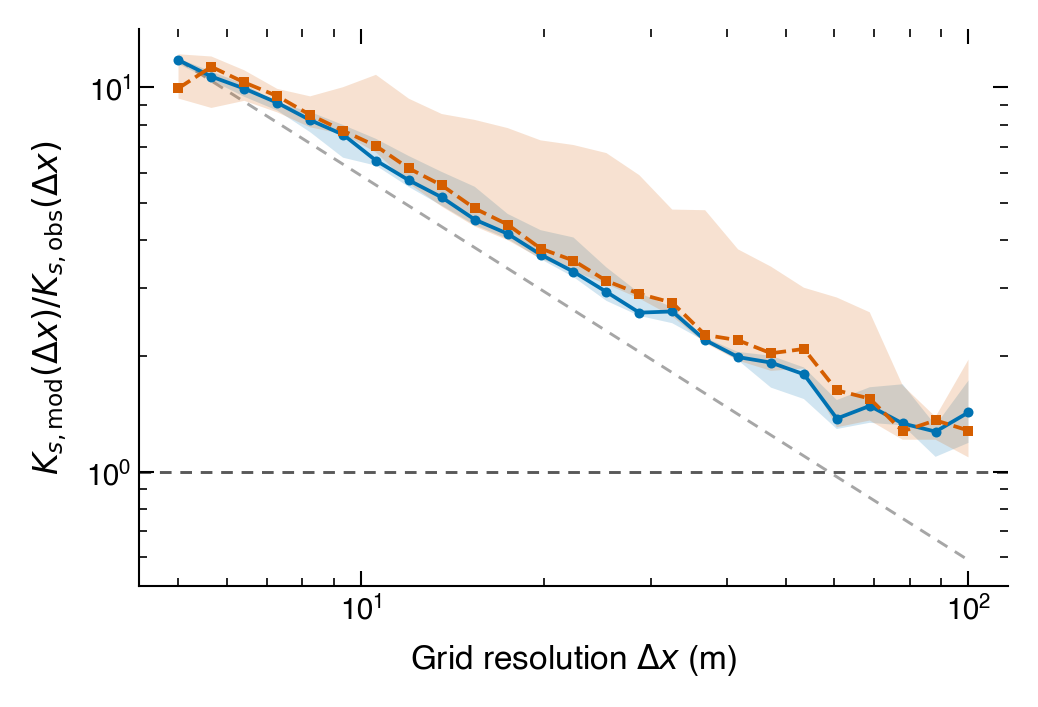

In [4]:
from matplotlib.ticker import LogLocator, LogFormatterMathtext

# -------------------------
# Plot 1: ratio (MEDIAN + IQR ONLY; GM vs AP)
# -------------------------
tile_data = by_tile_from_all_results(all_results)
dx_all = np.array(sorted({float(r["dx"]) for r in all_results}), dtype=float)

# Color-blind friendly, high-contrast pair (Okabe–Ito palette)
# (Good in print, and still distinct when desaturated)
COL_GM = "#0072B2"  # blue
COL_AP = "#D55E00"  # vermillion

fig1, ax1 = plt.subplots(figsize=(3.5, 2.4))

def plot_median_iqr(ax, x, med, q25, q75, color, marker, linestyle):
    x = np.asarray(x, float)
    med = np.asarray(med, float)
    q25 = np.asarray(q25, float)
    q75 = np.asarray(q75, float)

    m = np.isfinite(x) & np.isfinite(med) & np.isfinite(q25) & np.isfinite(q75) & (med > 0) & (q25 > 0) & (q75 > 0)
    if np.sum(m) < 2:
        return

    # IQR band: no edges, clearly a band (not lines)
    ax.fill_between(
        x[m], q25[m], q75[m],
        facecolor=color,
        alpha=0.18,
        linewidth=0,
        edgecolor="none",
        interpolate=True,
        zorder=1,
    )

    # Median: thin line + small markers
    ax.plot(
        x[m], med[m],
        linestyle + marker,
        color=color,
        lw=0.9,
        ms=2.4,
        mfc=color,
        mec=color,
        mew=0.0,
        zorder=3,
    )

# Compute and plot GM and AP summaries
med_gm, q25_gm, q75_gm = group_stats_ratio(tile_data, "GM", dx_all)
med_ap, q25_ap, q75_ap = group_stats_ratio(tile_data, "AP", dx_all)

plot_median_iqr(ax1, dx_all, med_gm, q25_gm, q75_gm, COL_GM, marker="o", linestyle="-")
plot_median_iqr(ax1, dx_all, med_ap, q25_ap, q75_ap, COL_AP, marker="s", linestyle="--")

# Reference: model = observed
ax1.axhline(1.0, lw=0.7, color="0.35", ls="--", dashes=(4, 3), zorder=0)

# -1 slope guide (anchor to GM median at finest valid dx; else AP)
def _first_valid(x, y):
    j = np.where(np.isfinite(x) & np.isfinite(y) & (y > 0))[0]
    return j[0] if j.size else None

j0 = _first_valid(dx_all, med_gm)
anchor_series = med_gm
if j0 is None:
    j0 = _first_valid(dx_all, med_ap)
    anchor_series = med_ap

if j0 is not None:
    dx0 = dx_all[j0]
    y0 = anchor_series[j0]
    dx_line = np.array([np.nanmin(dx_all), np.nanmax(dx_all)], dtype=float)
    guide = y0 * (dx_line / dx0) ** (-1.0)
    ax1.plot(dx_line, guide, "--", lw=0.7, color="0.65", dashes=(4, 3), zorder=0)

# Axes / formatting (Nature-ish)
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xlabel(r"Grid resolution $\Delta x$ (m)")
ax1.set_ylabel(r"$K_{s,\mathrm{mod}}(\Delta x)/K_{s,\mathrm{obs}}(\Delta x)$")

ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)

ax1.xaxis.set_major_locator(LogLocator(base=10.0, subs=(1.0,), numticks=10))
ax1.yaxis.set_major_locator(LogLocator(base=10.0, subs=(1.0,), numticks=10))
ax1.xaxis.set_major_formatter(LogFormatterMathtext(base=10.0))
ax1.yaxis.set_major_formatter(LogFormatterMathtext(base=10.0))
ax1.tick_params(which="both", pad=2)

fig1.tight_layout()

# Vector export for Illustrator:
# fig1.savefig("ratio_vs_dx_median_IQR_GM_AP.pdf", format="pdf", bbox_inches="tight", pad_inches=0.02)

plt.show()
